In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

import programs.NN as NN
import programs.visualize as vis
import programs.misc as misc

from programs.Poisson_Convection import *
from programs.misc import *

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

cuda:0


In [3]:
# Ширина трещины
w = 1.

# Вязкость
mu0 = 0.01

# Максимальная концентрация проппанта
cmax = 1.

# Концентрация входящего проппанта в первый момент времени
c1 = 0.4

# Концентрация входящего проппанта во второй момент времени
c2 = 0.4

# Время перехода
t1 = 1.

# Скорость потока
v_in = 1.

# Длина интервала перфорации
chi = 0.4

# Степень в вязкости
beta = -2.5

# Число точек для ГУ (возводится в квадрат)
BC_points = 32

# Число точек для НУ (возводится в квадрат)
IC_points = 32

# Число точек коллокации (возводится в куб)
PDE_points = 48

# Границы для x,y,t
x_min, x_max, y_min, y_max, t_min, t_max = 0.0, 1.0, 0.0, 1.0, 0.0, 2.0
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Массивы условий
cond = -12 * mu0 * v_in / w**2
b1 = (1 - c1/cmax)**(beta)
b2 = (1 - c2/cmax)**(beta)
c_condition = [[0, 0, c1, 0], [2, 2, 1.5, 3], [False, False, True, True]]
p_condition = [[0, 0, cond * (1 - c1/cmax)**(beta), cond], [2, 2, 2, 2], [False, False, True, True]]
print (cond * (1 - c1/cmax)**(beta), cond)
print (misc.viscosity(mu0,c1,cmax,beta), misc.compare_viscosity(c1,c2,cmax,beta))

-0.43033148291193524 -0.12
0.03586095690932794 1.0


In [4]:
net = Poisson_Convection(w=w, mu0=mu0, cmax=cmax, v_in=v_in, c1=c1, c2=c2, t1=t1, chi=chi, beta=beta,
                         c_cond=c_condition, p_cond=p_condition,
                         size=boundaries, PDE_points=PDE_points, BC_points=BC_points, IC_points=IC_points)
net.model.apply(NN.Net.init_weights)

Net(
  (layers): Sequential(
    (input): Linear(in_features=3, out_features=48, bias=True)
    (input_activation): Sin()
    (hidden_0): Linear(in_features=48, out_features=48, bias=True)
    (activation_0): Sin()
    (hidden_1): Linear(in_features=48, out_features=48, bias=True)
    (activation_1): Sin()
    (hidden_2): Linear(in_features=48, out_features=48, bias=True)
    (activation_2): Sin()
    (hidden_3): Linear(in_features=48, out_features=48, bias=True)
    (activation_3): Sin()
    (output): Linear(in_features=48, out_features=3, bias=True)
  )
  (sin): Sin()
)

In [5]:
# net.full_save("data/serv_48_2pde","data/serv_48_2pded")
net.full_load("data/serv_48_2pde","data/serv_48_2pded.npy")
# net.full_load("data/CL_w,[1, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]/0.9",
              # "data/CL_w,[1, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]/0.9_data.npy")

# for i in range(len(net.c)):
#     print (i+1, round(net.p[i].item(),4), round(net.x[i].item(),4), round(net.y[i].item(),4), round(net.t[i].item(),4))

# for i in range(len(net.IC_c)):
    # print (i+1, net.IC_c[i].item(), net.IC_x[i].item(), net.IC_y[i].item(), net.IC_t[i].item())
    # print (net.IC_y[i].item())

/home/i_melnikov/PyTorch_PiNN_for_Poisson_convection_equations_system/programs/Poisson_Convection.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state

In [6]:
weights = [1,1,1,1,1,1]
# net.weights = weights/np.max(weights)
print (net.weights)
net.Adam_epochs = 1000
start_time = time.time()
# net.makeIBC()
net.train()
# net.full_save("data/serv_hc","data/serv_hcd")
# for i in range(10):
#     print([0 for i in range(100)])
#     net.makeIBC()
#     net.train()
#     net.full_save(f"data/serv_48_{i}",f"data/serv_48_{i}d")
# net.CL_epochs = [1000 for i in range(100)]
# parameters = {'w':[1,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.901,0.9]}
# parameters = {'w':np.round(np.arange(0.89,0.09,-0.01),2).tolist()}
# net.CL_train(constants=parameters)
end_time = time.time()
elapsed_time = end_time - start_time

[1, 1, 1, 1, 1, 1]
|     Epochs     |      PDE loss       |     p corr loss     |       IC loss       |       BC loss       |    Summary loss     |      time      |
|       0        |      0.295938       |      0.052878       |      0.010994       |      0.536687       |      0.896497       |    1.643997    |
|       10       |      0.042121       |      0.007414       |      0.006702       |      0.148353       |       0.20459       |    0.82386     |
|       20       |      0.019204       |       0.00023       |      0.001323       |      0.133274       |      0.154031       |    0.823792    |
|       30       |      5.583296       |      0.000105       |      0.008872       |      0.144447       |       5.73672       |    0.825706    |
|       40       |      0.062733       |      0.000351       |       0.09421       |      0.261462       |      0.418757       |    0.823769    |
|       50       |      0.003293       |      0.000144       |       0.00668       |      0.099016       

KeyboardInterrupt: 

In [ ]:
print('Elapsed time: ', elapsed_time)

0.0021220617927610874 26957


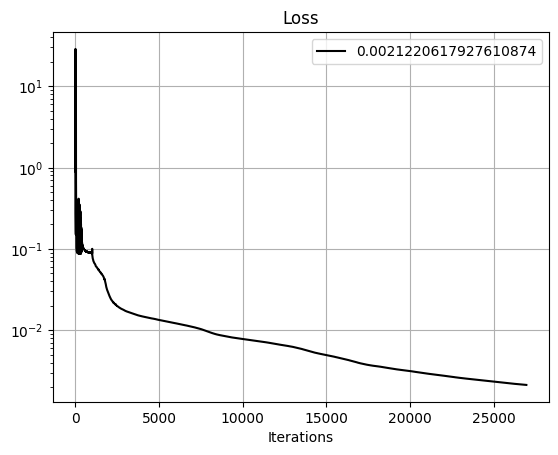

In [6]:
print (net.losses[-1], len(net.losses))
vis.plot_loss(net.losses)
plt.legend()
plt.savefig("gifs/losses")
# plt.ylim(1e-5,1e2)

In [29]:
net.eval_()

try:
  del u,c,p,u_x,u_y
except NameError:
  None

Nx = 71
Ny = 71
Nt = 101

t = torch.linspace(t_min, t_max, Nt)
x = torch.linspace(x_min, x_max, Nx)
y = torch.linspace(y_min, y_max, Ny)

mesh_XYT = torch.stack(torch.meshgrid(x,y,t, indexing='ij')).reshape(3, -1).T

X = torch.autograd.Variable(mesh_XYT[:,0], requires_grad=True)#.reshape(-1,1)
Y = torch.autograd.Variable(mesh_XYT[:,1], requires_grad=True)#.reshape(-1,1)
T = torch.autograd.Variable(mesh_XYT[:,2], requires_grad=True)#.reshape(-1,1)

n = net.model([X,Y,T], net.transform)
# n[:,0] *= X * T
# n[:,0] += (misc.psi_th(Y, 0.3, 0.7) * net.c1 * misc.delta_th(X))
print (n.shape)
mu = net.mu0*(1 - n[:,0]/net.cmax)**(beta)
ux = -net.w**2 * n[:,1] / 12 / mu 
uy = -net.w**2 * n[:,2] / 12 / mu

cc = NN.Net.derivative(n[:,0], T) + NN.Net.derivative(n[:,0]*ux, X) + NN.Net.derivative(n[:,0]*uy, Y)
cc = cc.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

u = NN.Net.derivative(ux,X) + NN.Net.derivative(uy,Y)
u = u.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

c    = n[:,0].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
px   = n[:,1].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
py   = n[:,2].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

mu   = mu.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
ux   = ux.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
uy   = uy.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

del X,Y,T,mesh_XYT,n

t = np.linspace(t_min, t_max, Nt)
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)

torch.Size([509141, 3])


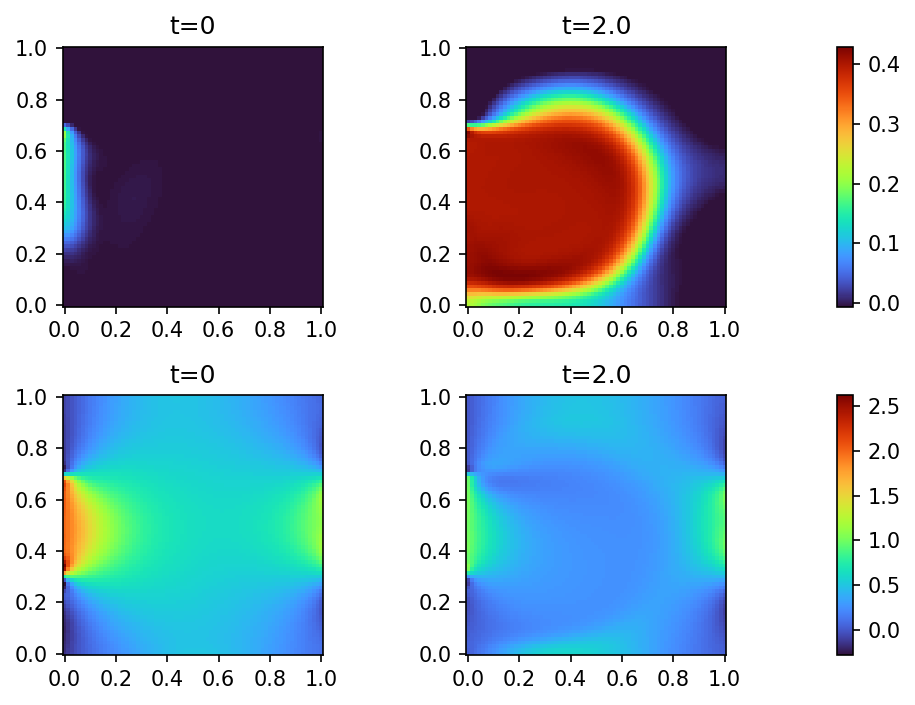

In [31]:
vis.plot_results([c[0],c[-1],ux[0],ux[-1]],[x_min, x_max, y_min, y_max], t_max, Nx, Ny)

-0.4303314685821533
-0.11999999731779099


([<matplotlib.axis.XTick at 0x7fe8ec9c68e0>,
 [Text(0.0, 0, '0.0'),
  Text(0.3, 0, '0.3'),
  Text(0.7, 0, '0.7'),
  Text(1.0, 0, '1.0')])

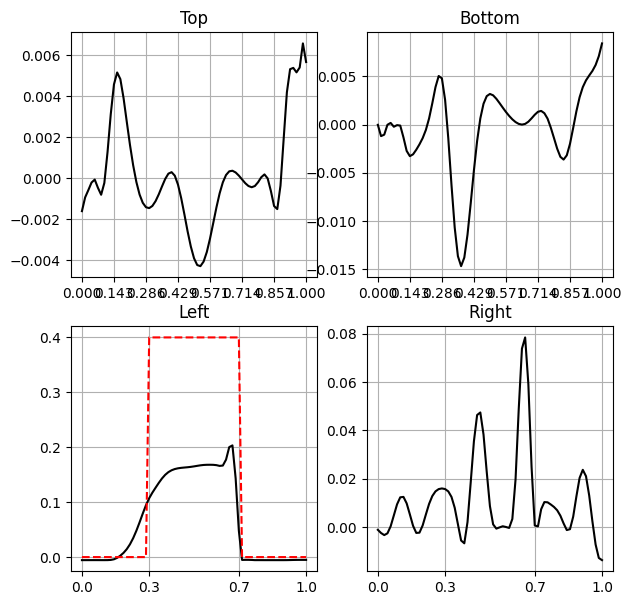

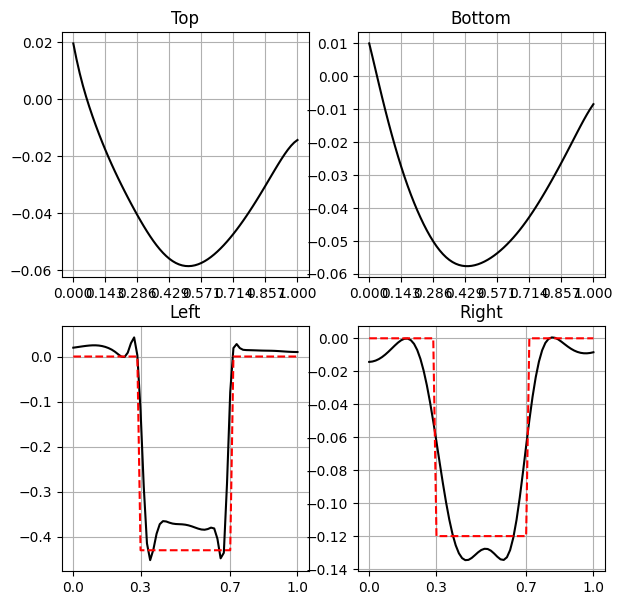

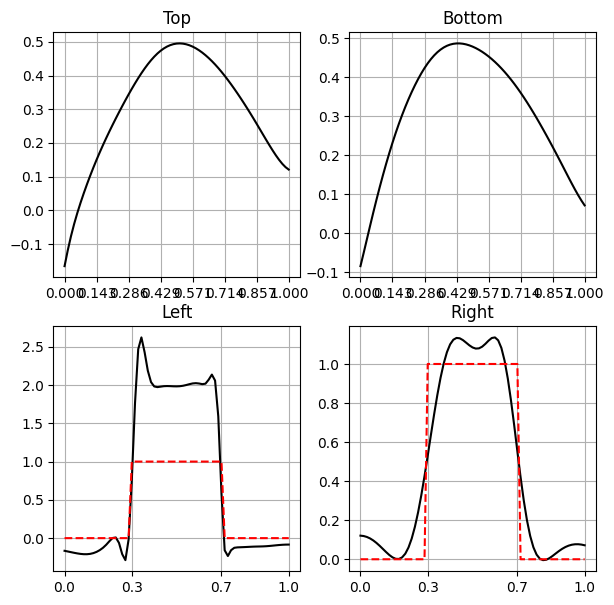

In [32]:
print (net.p_cond[0][2].min().item())
print (net.p_cond[0][3].min().item())

i = -0
vis.plot_BC(c[i], x, y, 1/(Nx-1), 1/(Ny-1), [1,1,0,1])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, c1, 0), c='red', ls='--')
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, c2, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

vis.plot_BC(px[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.p_cond[0][2].min().item(), 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.p_cond[0][3].min().item(), 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

vis.plot_BC(ux[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.v_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.v_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

0.0


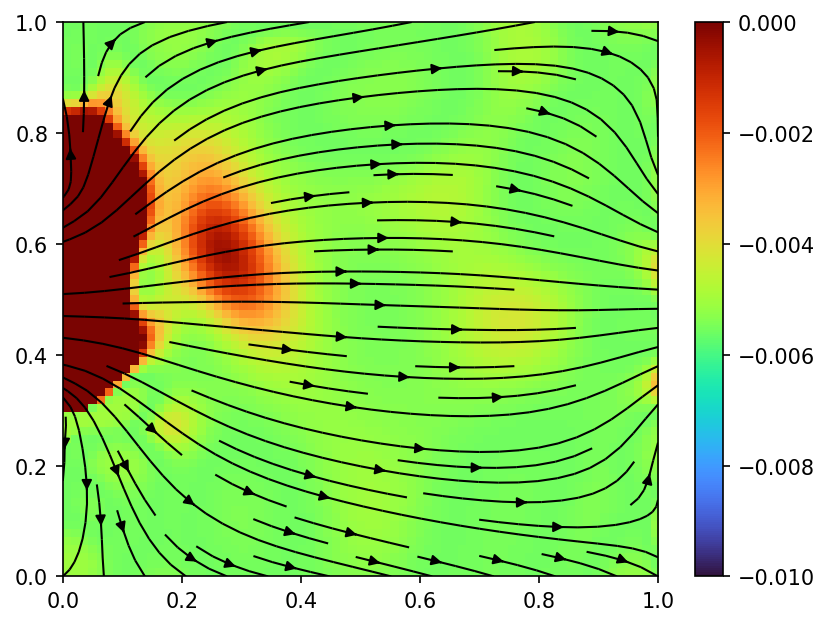

In [33]:
mesh_x, mesh_y = np.meshgrid(x,y)
# vis.plot(c[0], limits=[0,1,0,1])
fig, ax = plt.subplots()
fig.dpi = 150
ax1 = ax.twinx()
i = 0
print(t[i]) 
# imsh = ax.imshow(np.where(np.abs((u_xx+u_yy)[0])<=0.01, np.nan, (u_xx+u_yy)[0]), cmap = 'turbo', extent = [0, 1, 0, 1], interpolation='none', aspect='auto')
imsh = ax.imshow(c[i], cmap = 'turbo', extent = [0, 1, 0, 1], interpolation='none', aspect='auto')
# ax.set_aspect('equal', 'datalim')
ax1.axis('off')
# a.set_aspect('equal', 'box')
strm = ax1.streamplot(mesh_x, mesh_y, ux[i], uy[i], linewidth=1, color='black')
# fig.colorbar(strm.lines)
imsh.set_clim(-0.01,0)
plt.colorbar(imsh)

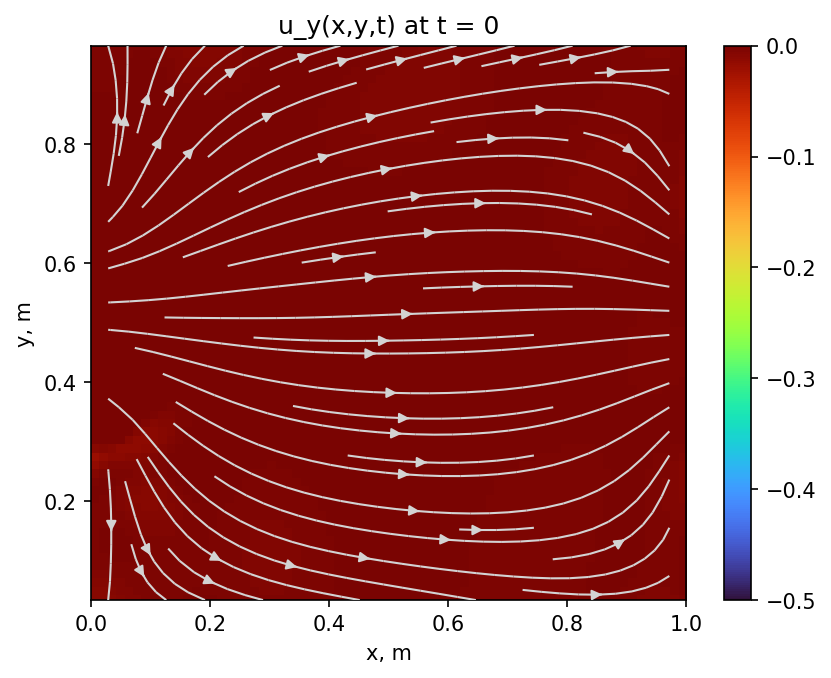

In [27]:
vis.anim_result(c,
                t_max/Nt,
                clims=[-0.5,0],
                streamplot_data=[mesh_x[2:-2,2:-2],mesh_y[2:-2,2:-2],ux[:,2:-2,2:-2],uy[:,2:-2,2:-2]],
                name='serv_test',
                title='u_y(x,y,t)',
                colour='turbo',
                path='gifs',
                savetogif=True,
                showMe=True,
                )